**CNN Model for MIT-BIH dataset:**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers


%matplotlib inline

In [ ]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

In [ ]:
def denoise(data):
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))

    datarec = pywt.waverec(coeffs, 'sym4')

    return datarec

In [ ]:
path = '/content/drive/MyDrive/data_mit/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [ ]:
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt
records = list()
annotations = list()
filenames.sort()

In [ ]:
for f in filenames:
    filename, file_extension = os.path.splitext(f)

    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:37: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:64: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:37: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:64: SyntaxWarning: "is" with a literal. Did you mean "=="?


<ipython-input-8-5fd1909702d4>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
<ipython-input-8-5fd1909702d4>:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
<ipython-input-8-5fd1909702d4>:37: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
<ipython-input-8-5fd1909702d4>:64: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1 and not example_beat_printed:


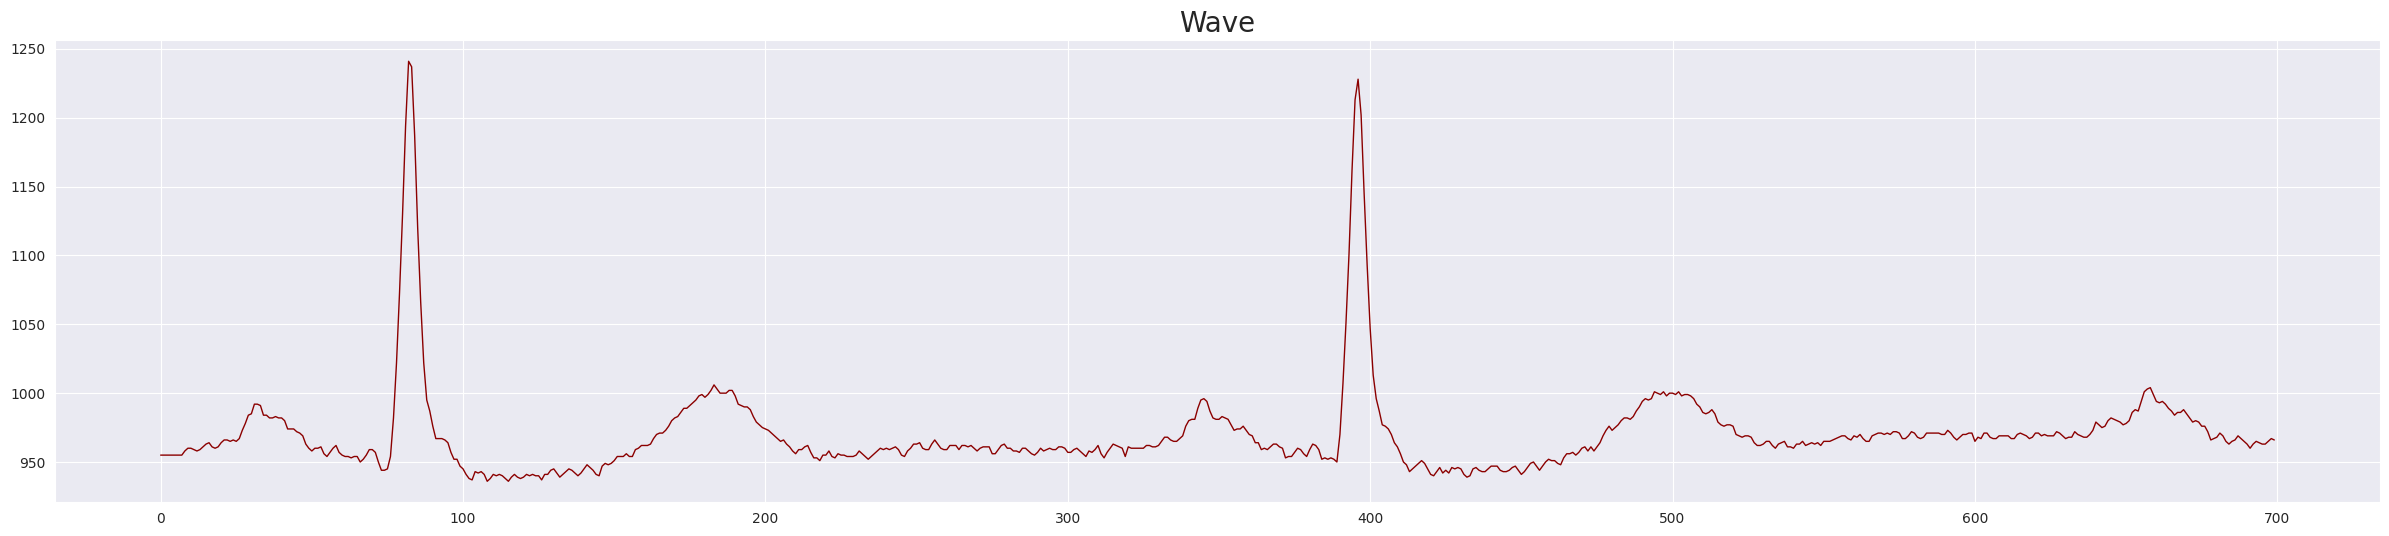

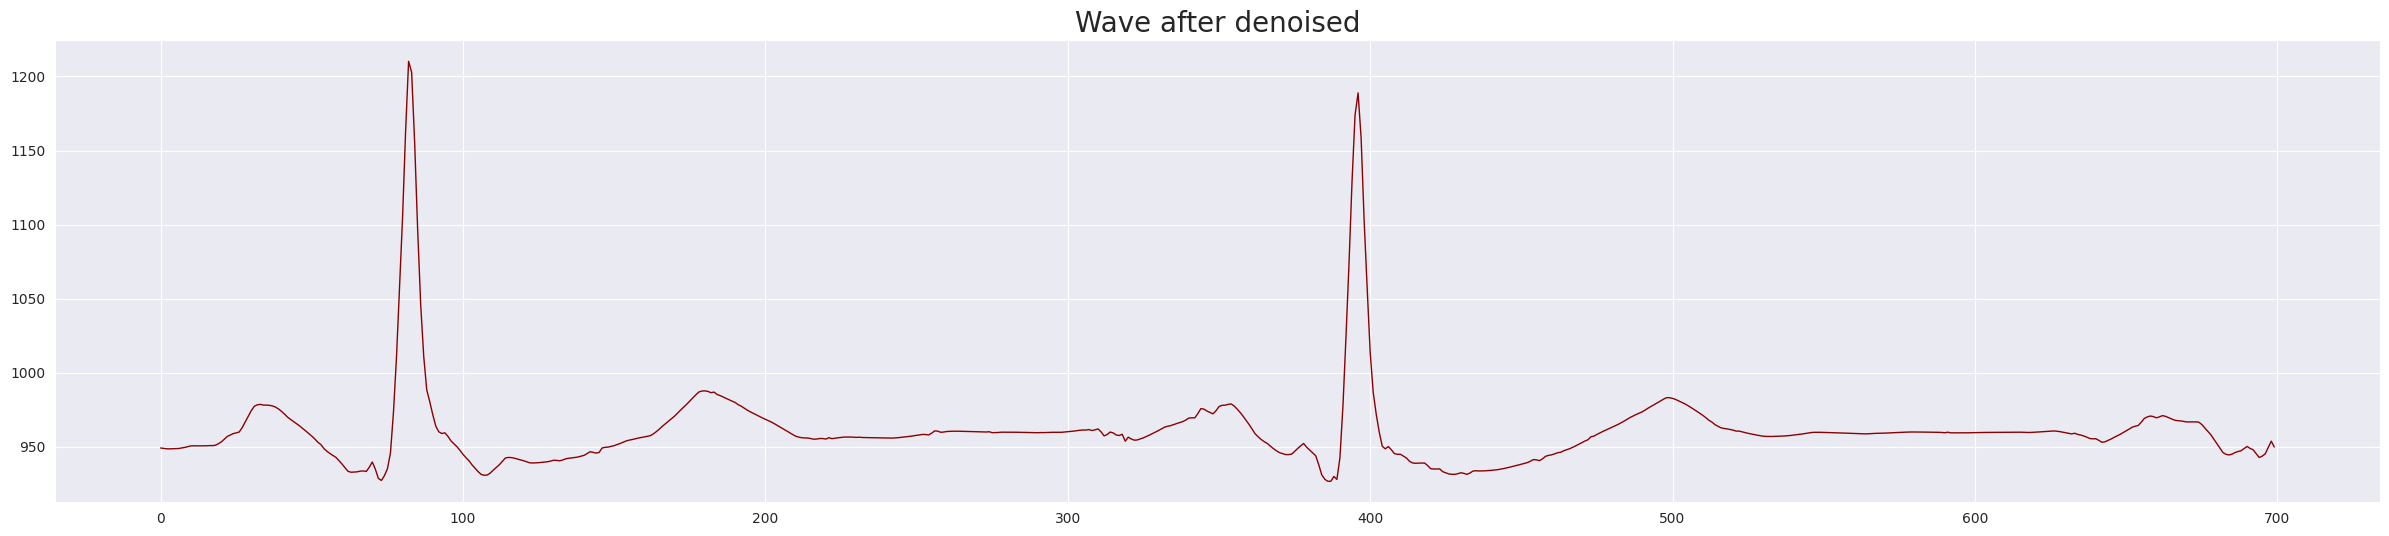

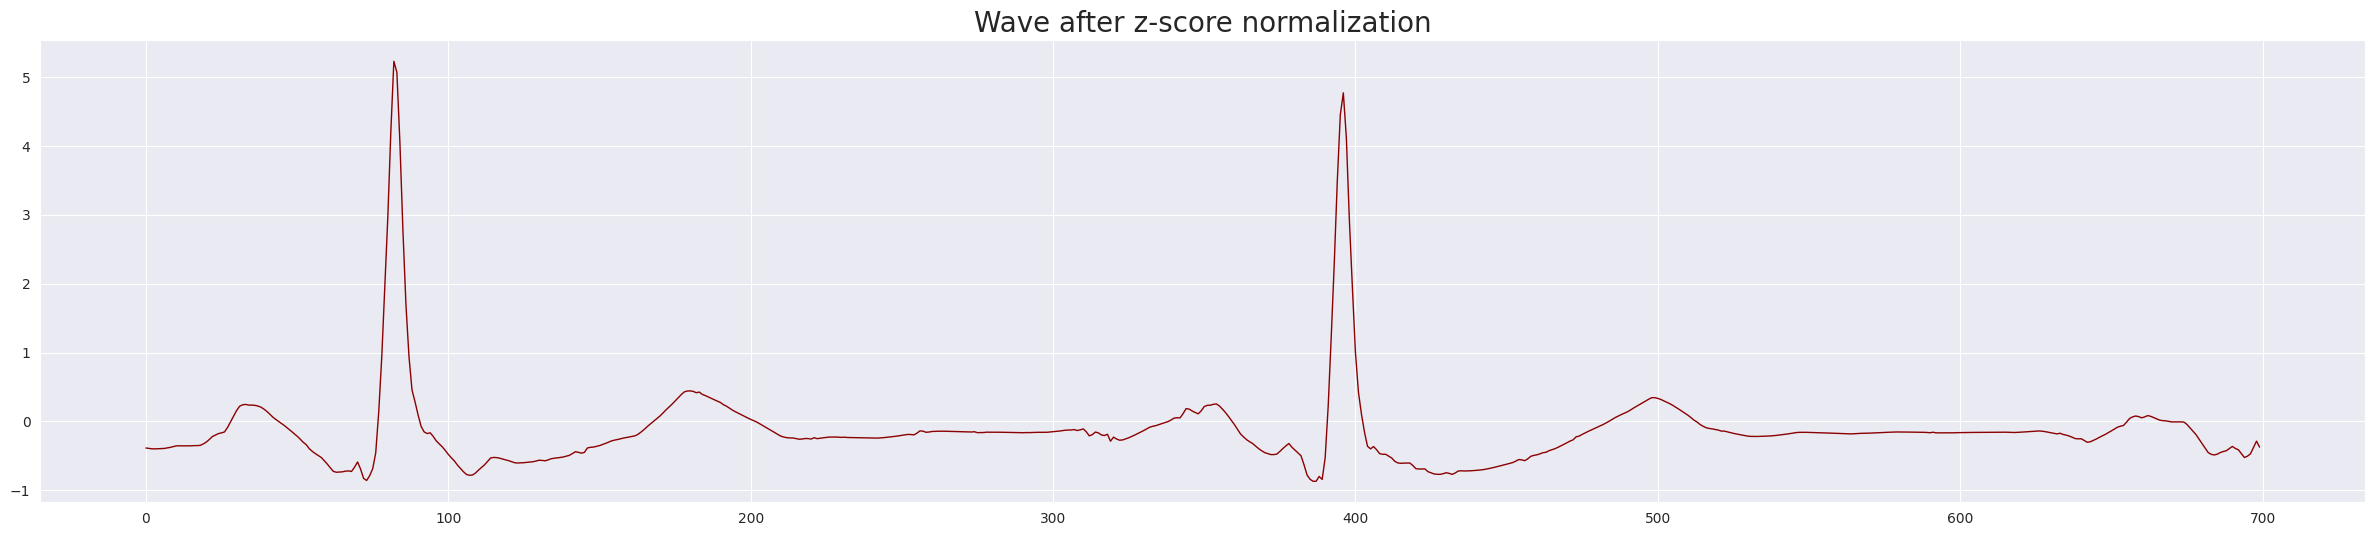

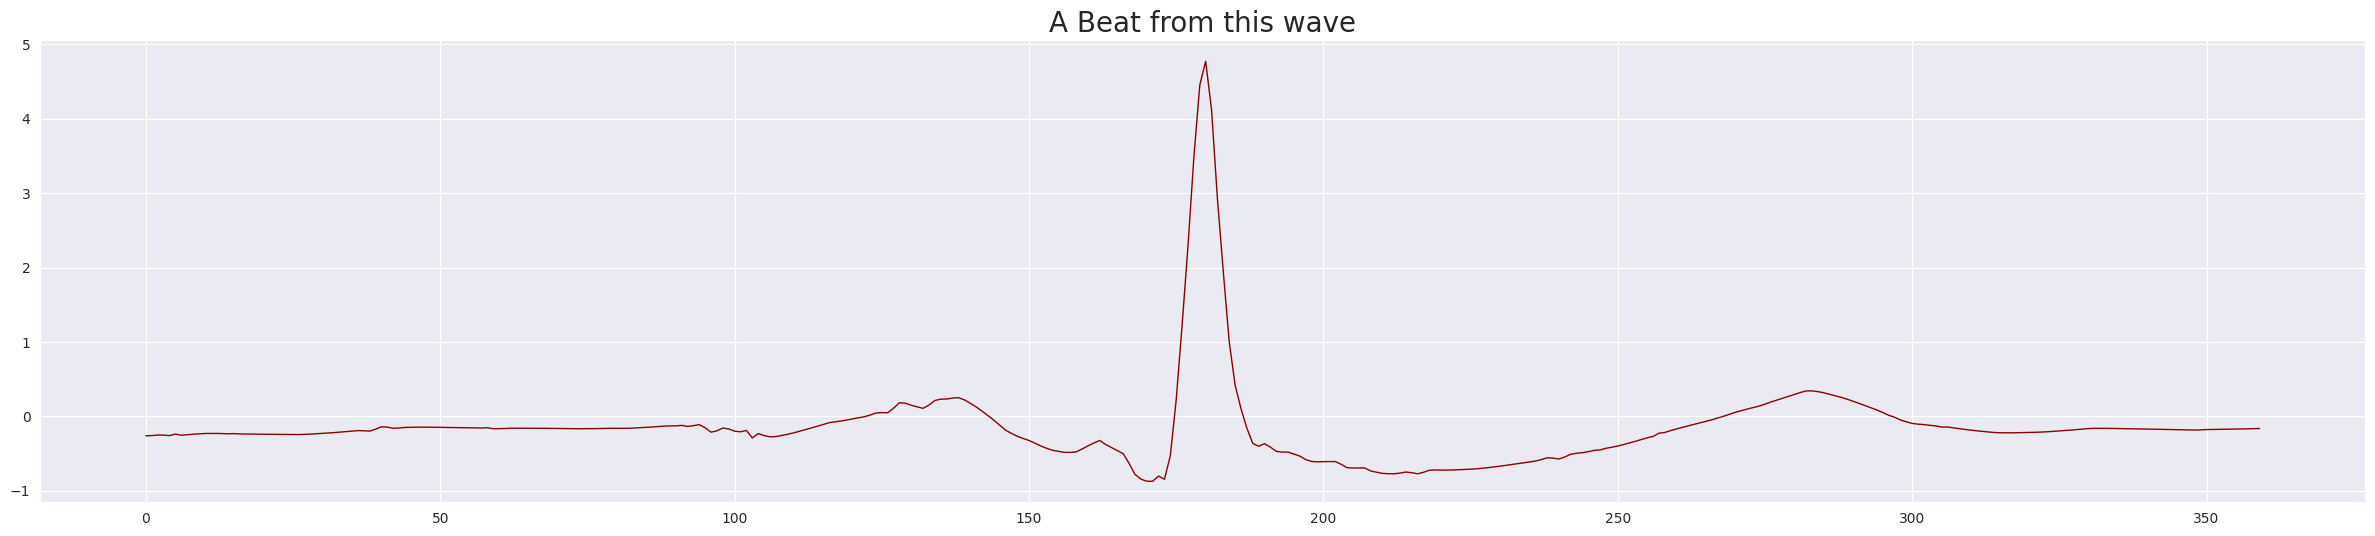

(100012, 360) (100012,)


In [ ]:
!pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_style('darkgrid')

for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1

    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title("Wave", fontsize=20)
        plt.plot(signals[0:700], color='darkred')
        plt.show()

    signals = denoise(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title("Wave after denoised", fontsize=20)
        plt.plot(signals[0:700], color='darkred')
        plt.show()

    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title("Wave after z-score normalization", fontsize=20)
        plt.plot(signals[0:700], color='darkred')
        plt.show()

    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     # REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat
                    if r is 1 and not example_beat_printed:
                        plt.title("A Beat from this wave", fontsize=20)
                        plt.plot(beat, color='darkred')
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

In [ ]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])

print(np.shape(X))

(100012, 361)


0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 360, dtype: int64


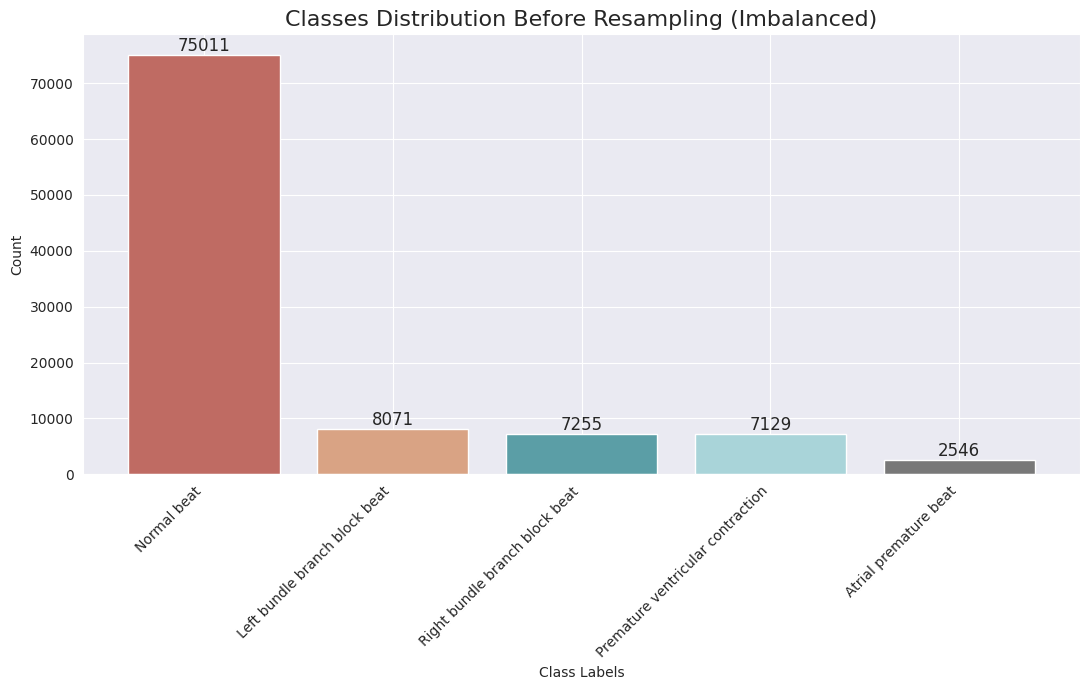

In [ ]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)

class_labels = ['Normal beat', 'Left bundle branch block beat', 'Right bundle branch block beat', 'Premature ventricular contraction', 'Atrial premature beat']
colors = ['#bf6b63', '#d9a384', '#5b9ea6', '#a9d4d9', '#787878']

plt.figure(figsize=(11, 7))
plt.bar(class_labels, per_class, color=colors)

# Add labels to the bars
for i, count in enumerate(per_class):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12)

plt.title('Classes Distribution Before Resampling (Imbalanced)', fontsize=16)
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

A method called **resampling**, which adjusts the number of majority and minority instances, is usually used to **solve the imbalance in training data**. Although resampling can **eliminate imbalances**, it may cause data complexity that deteriorates classification accuracy:

In [ ]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: 360, dtype: int64


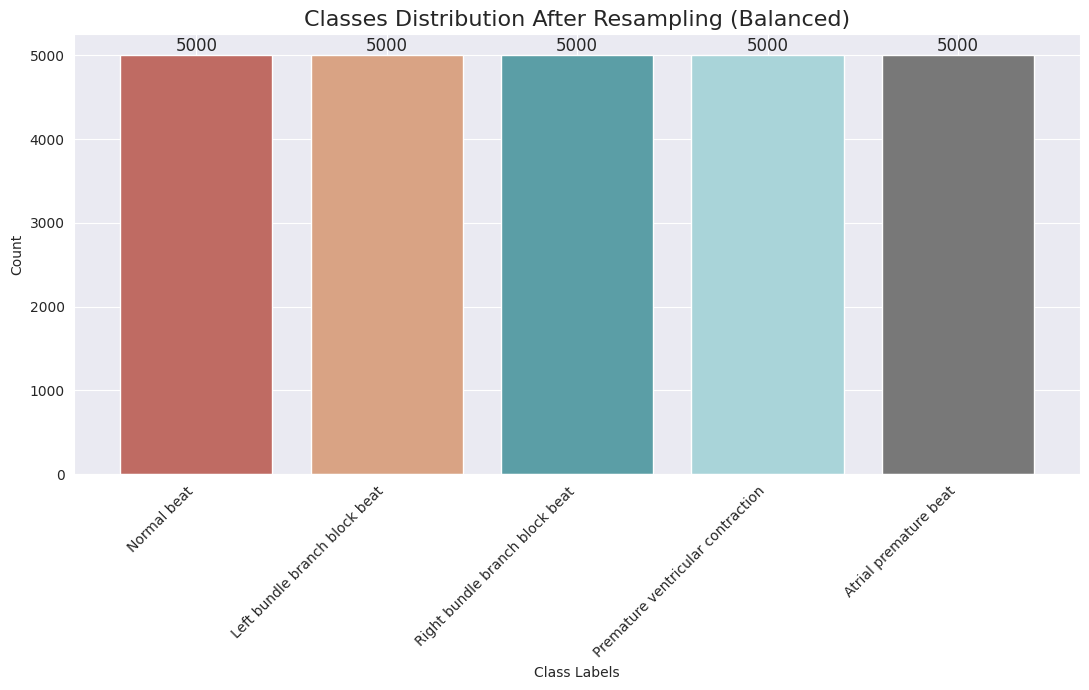

In [ ]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)

class_labels = ['Normal beat', 'Left bundle branch block beat', 'Right bundle branch block beat', 'Premature ventricular contraction', 'Atrial premature beat']
colors = ['#bf6b63', '#d9a384', '#5b9ea6', '#a9d4d9', '#787878']

plt.figure(figsize=(11, 7))
plt.bar(class_labels, per_class, color=colors)

# Add labels to the bars
for i, count in enumerate(per_class):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12)

plt.title('Classes Distribution After Resampling (Balanced)', fontsize=16)
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [ ]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [ ]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 360, 1) (5000, 360, 1)


In [ ]:
model = Sequential()

model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu', input_shape=(360, 1)))
model.add(AvgPool1D(pool_size=3, strides=2))

model.add(Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))
model.add(AvgPool1D(pool_size=3, strides=2))

model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))
model.add(AvgPool1D(pool_size=3, strides=2))

model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))
model.add(AvgPool1D(pool_size=3, strides=2))

model.add(Conv1D(filters=256, kernel_size=21, padding='same', activation='relu'))
model.add(AvgPool1D(pool_size=3, strides=2))

model.add(Flatten())

model.add(Dropout(0.5))

model.add(Dense(35, kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))

model.add(Dense(5, kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))

model.add(Softmax())

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 360, 16)           224       
                                                                 
 average_pooling1d (AverageP  (None, 179, 16)          0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 179, 32)           7712      
                                                                 
 average_pooling1d_1 (Averag  (None, 89, 32)           0         
 ePooling1D)                                                     
                                                                 
 conv1d_2 (Conv1D)           (None, 89, 64)            34880     
                                                                 
 average_pooling1d_2 (Averag  (None, 44, 64)           0

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [ ]:
history = model.fit(train_x, train_y, batch_size=36, epochs=80, verbose=1, validation_data=(test_x, test_y))

Epoch 1/80
556/556 [==============================] - 79s 142ms/step - loss: 0.3208 - accuracy: 0.8883 - val_loss: 0.1151 - val_accuracy: 0.9658
Epoch 2/80
556/556 [==============================] - 78s 140ms/step - loss: 0.1222 - accuracy: 0.9633 - val_loss: 0.0983 - val_accuracy: 0.9658
Epoch 3/80
556/556 [==============================] - 77s 138ms/step - loss: 0.0854 - accuracy: 0.9758 - val_loss: 0.0783 - val_accuracy: 0.9778
Epoch 4/80
556/556 [==============================] - 78s 141ms/step - loss: 0.0786 - accuracy: 0.9772 - val_loss: 0.0838 - val_accuracy: 0.9720
Epoch 5/80
556/556 [==============================] - 77s 139ms/step - loss: 0.0591 - accuracy: 0.9840 - val_loss: 0.0519 - val_accuracy: 0.9850
Epoch 6/80
556/556 [==============================] - 77s 139ms/step - loss: 0.0577 - accuracy: 0.9845 - val_loss: 0.0565 - val_accuracy: 0.9862
Epoch 7/80
556/556 [==============================] - 77s 139ms/step - loss: 0.0515 - accuracy: 0.9872 - val_loss: 0.0654 - val_ac

In [ ]:
model.save('/content/drive/MyDrive/Saved_CNN_Models/CNN_model6.h5')

# To load model:
# from keras.models import load_model
# loaded_model = load_model('/content/drive/MyDrive/Saved_CNN_Models/CNN_model6.h5')

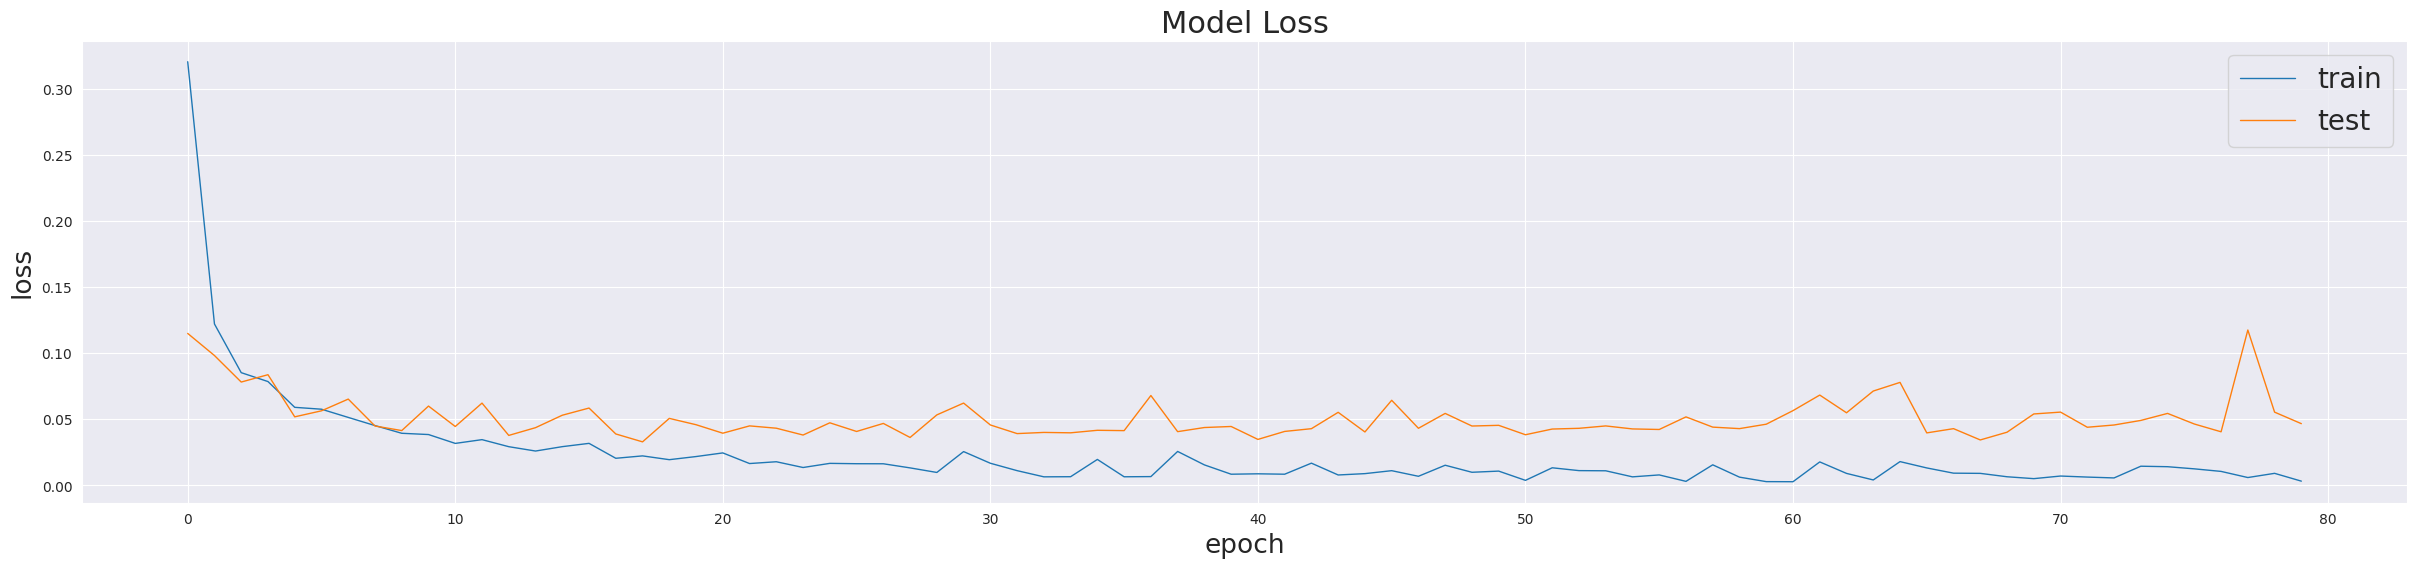

In [ ]:
sns.set_style('darkgrid')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize=22)
plt.ylabel('Loss', fontsize=19)
plt.xlabel('Epoch', fontsize=19)
plt.legend(['train', 'test'], prop = {'size' : 20}, loc='upper right')
plt.show()

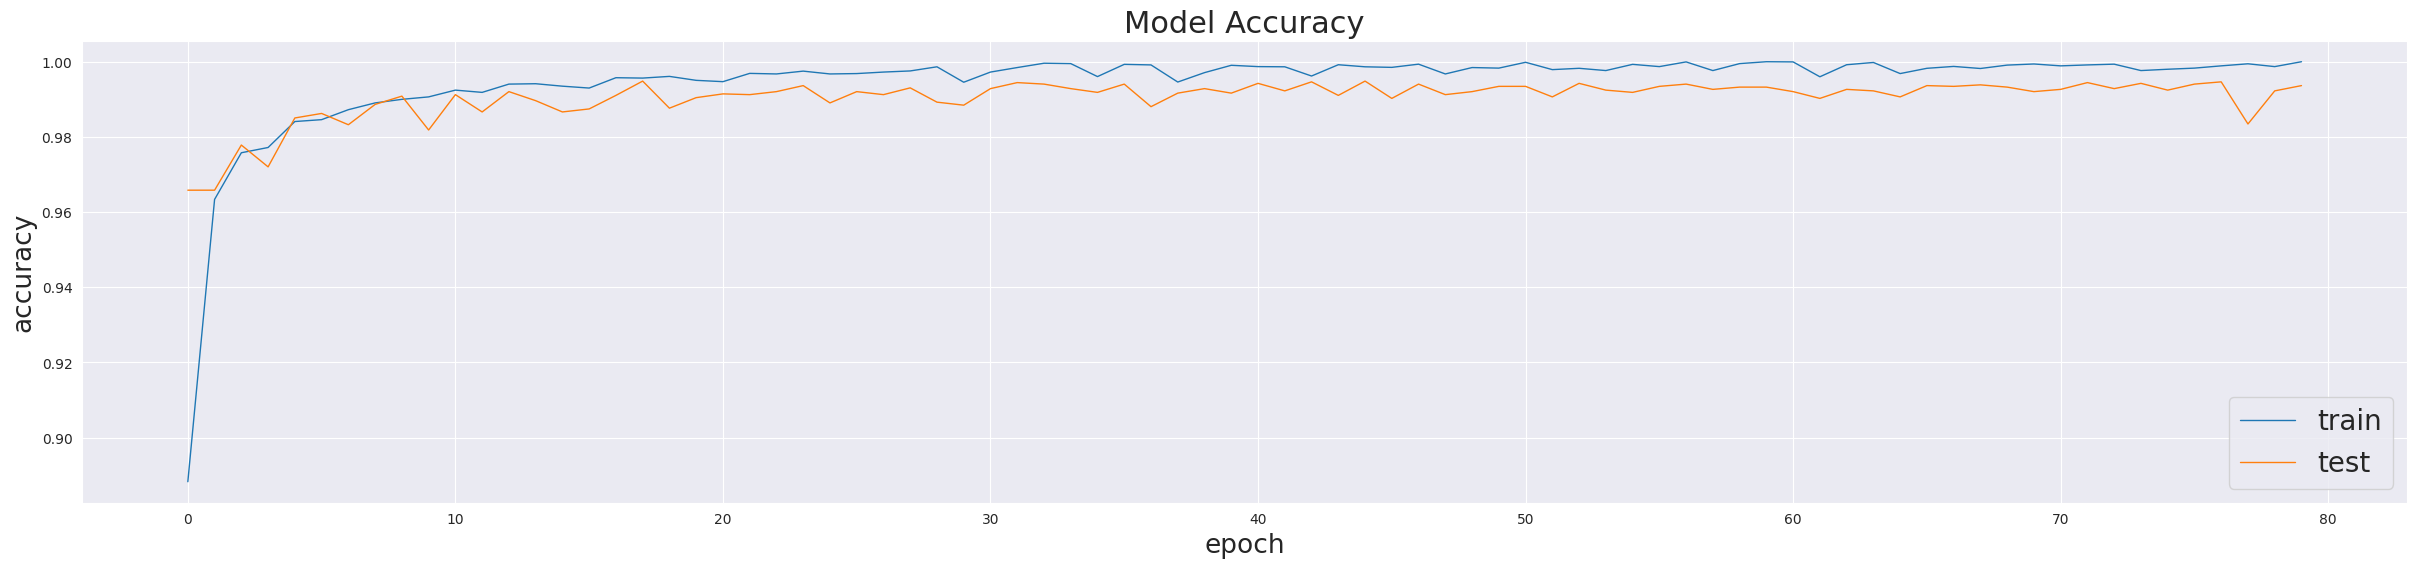

In [ ]:
sns.set_style('darkgrid')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', fontsize=22)
plt.ylabel('Accuracy', fontsize=19)
plt.xlabel('Epoch', fontsize=19)
plt.legend(['train', 'test'], prop = {'size' : 20}, loc='lower right')
plt.show()

In [ ]:
score = model.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

157/157 [==============================] - 5s 31ms/step - loss: 0.0468 - accuracy: 0.9936
Test Loss: 0.046754706650972366
Test accuracy: 0.9936000108718872


In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report

# Evaluate the model on the test set
score = model.evaluate(test_x, test_y)

# Predict the classes for the test set
y_pred = model.predict(test_x)
y_pred = np.argmax(y_pred, axis=1)  # Convert one-hot encoded predictions to class labels

# Convert one-hot encoded true labels to class labels
y_true = np.argmax(test_y, axis=1)

# Calculate Precision, Recall, and F1 score
classification_rep = classification_report(y_true, y_pred, target_names=classes)
print(classification_rep)


157/157 [==============================] - 4s 24ms/step
              precision    recall  f1-score   support

           N       0.99      0.98      0.99      1014
           L       1.00      1.00      1.00       995
           R       1.00      1.00      1.00       999
           A       0.98      0.99      0.99       988
           V       1.00      1.00      1.00      1004

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



In [ ]:
classification_rep = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

# Extract the metrics for each class
metrics_dict = classification_rep['weighted avg']

# Calculate the average precision, recall, and F1-score
average_precision = metrics_dict['precision']
average_recall = metrics_dict['recall']
average_f1_score = metrics_dict['f1-score']

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average F1-score:", average_f1_score)


Average Precision: 0.9936262657374435
Average Recall: 0.9936
Average F1-score: 0.9936008038718422
